In [1]:
import pandas as pd
import numpy as np
import logging
import random 
import matplotlib.pyplot as plt

In [2]:
ACTIONS = ['←', '→', '↑', '↓']
threshold = 0.05

In [3]:
def moveOneStep(current, action, shape): # Equivalent to a transition matrix
    current = np.copy(current)
    if action == '↑': #'Up':
        current[0] = max(current[0] - 1, 0)
    if action == '↓': #'Down':
        current[0] = min(current[0] + 1, shape[0] - 1)
    if action == '←': #'Left':
        current[1] = max(current[1] - 1, 0)
    if action == '→': #'Right':
        current[1] = min(current[1] + 1, shape[1] - 1)
    return current

In [6]:
class MazeAgent:
    def __init__(self, rewards, start=None, end=None, gamma=0.95, barrierThreshold=-50):
        '''start, end: tuples indicating the start and end of the maze
           rewards: the reward matrix. NaN value means unpassable wall in the maze.
        '''
        self._maze = rewards
        self._shape = np.array(rewards.shape)
        self._start = start if start is not None else np.array((0, 0))
        self._end = end if end is not None else self._shape - np.array((1, 1))
        self.value = np.zeros(rewards.shape)
        self.actionValue = np.zeros(list(rewards.shape) + [4])
        self.gamma = gamma
        self.barrierThreshold = barrierThreshold

    def _initialize(self, newStart=None):
        '''Initialize the agent to the starting point of the maze'''
        self._current = np.copy(self._start) if newStart is None else newStart
        # Randomize policies
        self._policy = np.array(random.choices(ACTIONS, k=self._shape[0] * self._shape[1])).reshape(self._shape)
        self._initialPolicy = np.copy(self._policy)
        self._policyZero = np.copy(self._policy)

    def _walkThroughEpsilon(self, maxIter=50000, policy=None):
        '''This is a brute force try where we assume we know the starting point and end point of the maze.
           Note that there is no information about the rewards at all in the Monte-Carlo methods
        '''
        count = 0
        policy = np.copy(self._policy) if policy is None else policy

        while not np.array_equal(self._current, self._end) and count < maxIter:
            self._prevCurrent = np.copy(self._current)
            epsilon = np.random.uniform()
            if epsilon < threshold:
                policy[self._current[0], self._current[1]] = random.choice(ACTIONS)
            self._current = moveOneStep(self._current, policy[self._current[0], self._current[1]],
                                        self._shape)
            if self._maze[self._current[0], self._current[1]] == -np.infty:
                self._current = np.copy(self._prevCurrent)
            count = count + 1

        # logger.info('Number of iterations: {}'.format(count))
        return policy

    def _policyEvaluation(self, iterations=100, policy=None):
        '''Given a policy (self._policy), we'd like to compute the value function V_pi'''
        barrierThreshold = self.barrierThreshold
        policy = self._policy if policy is None else policy
        #         self.value = np.zeros(self._maze.shape)
        for i in range(iterations):
            valueCurrent = np.copy(self.value)
            for row in range(self._shape[0]):
                for col in range(self._shape[1]):
                    if np.array_equal([row, col], self._end) or self._maze[
                        row, col] < barrierThreshold:  # When current state is at a barrier position
                        self.value[row, col] = self._maze[row, col]
                        continue
                    action = policy[row, col]
                    nextState = moveOneStep(np.array([row, col]), action, self._shape)
                    if self._maze[nextState[0], nextState[1]] < barrierThreshold:
                        nextState = np.array([row, col])
                    self.value[row, col] = self._maze[nextState[0], nextState[1]] + self.gamma * valueCurrent[
                        nextState[0], nextState[1]]
        return self.value

    def _policyImprovementFromValue(self):
        for row in range(self._shape[0]):
            for col in range(self._shape[1]):
                candidateRewards = []
                for action in ACTIONS:
                    if np.array_equal([row, col], self._end) or self._maze[
                        row, col] < self.barrierThreshold:  # When current state is at a barrier position
                        nextState = np.array([row, col])
                    else:
                        nextState = moveOneStep((row, col), action, self._shape)

                    reward = self._maze[nextState[0], nextState[1]] + self.gamma * self.value[
                        nextState[0], nextState[1]]
                    candidateRewards.append(reward)

                actionToChoose = ACTIONS[np.argmax(candidateRewards)]
                self._policy[row, col] = actionToChoose

    def runPolicyIterationFromValue(self, episodes=100, evaluationIters=50, printMaze=False):
        '''Main function for policy iteration based on value function'''
        for it in range(episodes):
            self._policyEvaluation(iterations=evaluationIters)
            self._policyImprovementFromValue()
            if printMaze:
                self._visualizeOneMatrix(self.value, actionMatrix=self._policy, colormap='PiYG',
                                         title='Value function and policy after learning')

    def _actionValueMonteCarlo(self, numberOfPaths=1000, alpha=0.25, iterationPolicyEval=200):
        '''Use MC to approximate action value function q_pi(s, a) given a policy pi'''
        self.actionValue = np.zeros(list(self._maze.shape) + [4])

        for i in range(numberOfPaths):
            self._current = np.copy(self._start)
            policyInitial = np.copy(self._initialPolicy)
            actionValueCurrent = np.copy(self.actionValue)
            newPolicy = self._walkThroughEpsilon(policy=policyInitial)
            newValue = self._policyEvaluation(iterations=iterationPolicyEval, policy=newPolicy)
            for row in range(self._shape[0]):
                for col in range(self._shape[1]):
                    action = newPolicy[row, col]
                    actionIndex = ACTIONS.index(action)
                    self.actionValue[row, col, actionIndex] = actionValueCurrent[row, col, actionIndex] + alpha * (
                                newValue[row, col] - actionValueCurrent[row, col, actionIndex])
                    self.value[row, col] = self.value[row, col] + alpha * (newValue[row, col] - self.value[row, col])
        return self.actionValue

    def _offPolicyOneEpisode(self, alpha=0.25, epsilon=0.95, epsilonNextActSARSA=0.95, method='qLearning'):
        self._current = np.copy(self._start)
        while not np.array_equal(self._current, self._end):
            current = self._current
            action = ACTIONS[self.actionValue[self._current[0], self._current[1]].argmax()]
            rand = np.random.uniform()
            if rand > epsilon:
                action = random.choice(pd.Index(ACTIONS).difference([action]))
            nextState = moveOneStep(self._current, action, self._shape)
            actionIndex = ACTIONS.index(action)

            if self._maze[nextState[0], nextState[1]] < self.barrierThreshold:
                nextState = current
            reward = self._maze[nextState[0], nextState[1]]
            if method == 'qLearning':
                newVal = self.actionValue[nextState[0], nextState[1]].max()
            else:
                nextActionIndex = self.actionValue[nextState[0], nextState[1]].argmax()
                rand = np.random.uniform()
                if rand > epsilonNextActSARSA:
                    nextActionIndex = random.choice(pd.Index(range(len(ACTIONS))).difference([nextActionIndex]))

                # nextAction = ATCIONS[nextActionIndex]
                newVal = self.actionValue[nextState[0], nextState[1], nextActionIndex]
            self.actionValue[current[0], current[1], actionIndex] = self.actionValue[
                                                                        current[0], current[1], actionIndex] + alpha * (
                                                                                reward + self.gamma * newVal -
                                                                                self.actionValue[current[0], current[
                                                                                    1], actionIndex])
            self._current = nextState
        self._policy = np.vectorize(lambda x: ACTIONS[x])(self.actionValue.argmax(axis=2))
        self.value = self.actionValue.max(axis=2)

    def runOffPolicyLearning(self, episodes=100, alpha=0.25, epsilon=0.95, epsilonNextActSARSA=0.95,
                             method='qLearning'):
        #         self.actionValue = np.random.uniform(size = (self._shape[0], self._shape[1], len(ACTIONS)))
        self.actionValue[self._end[0], self._end[1], :] = self._maze[self._end[0], self._end[1]]
        for ep in range(episodes):
            self._offPolicyOneEpisode(alpha, epsilon=epsilon, epsilonNextActSARSA=epsilonNextActSARSA,
                                      method=method)

    def _policyImprovementFromActionValue(self, policy, epsilon=0.95):
        policy = np.copy(policy)
        for row in range(self._shape[0]):
            for col in range(self._shape[1]):
                rand = np.random.uniform()
                actionToChoose = ACTIONS[np.argmax(self.actionValue[row, col])]
                policy[row, col] = actionToChoose if rand < epsilon else random.choice(
                    pd.Index(ACTIONS).difference([actionToChoose]))
        self._policy = np.copy(policy)
        self._initialPolicy = np.copy(policy)
        return policy

    def policyIterationMonteCarlo(self, policy, mcPaths=100, iterationPolicyEval=200, alpha=0.25):

        actionValue = self._actionValueMonteCarlo(numberOfPaths=mcPaths, iterationPolicyEval=iterationPolicyEval,
                                                  alpha=alpha)
        policy = self._policyImprovementFromActionValue(policy)
        return policy, actionValue

    def _visualizeOneMatrix(self, matrix, actionMatrix, title='', formatter='{:0.01f}', colormap='hot'):
        fig, ax = plt.subplots(figsize=(12, 8))

        plt.imshow(matrix, cmap=colormap, )
        plt.title(title)
        plt.colorbar()

        displayMatrix = np.array([formatter.format(val) + '\n' + action
                                  for val, action in zip(matrix.ravel(), actionMatrix.ravel())]).reshape(matrix.shape)
        for (i, j), z in np.ndenumerate(displayMatrix):
            ax.text(j, i, z, ha='center', va='center', size=15)

    def visualize(self):
        '''Visualize the maze, value function and policy'''
        ## Visualize maze
        self._visualizeOneMatrix(self._maze, actionMatrix=self._policyZero, title='Maze and initial policy')
        ## Visualize policy and value
        self._visualizeOneMatrix(self.value, actionMatrix=self._policy, colormap='PiYG',
                                 title='Value function and policy after learning')

    def runMonteCarlo(self, iterations=500, mcPaths=10):
        '''Run policy iteration algorithm by Monte-Carlo action-value evaluation'''
        for i in range(iterations):
            policy, actionValue = self.policyIterationMonteCarlo(self._initialPolicy, mcPaths=mcPaths)
        return policy, actionValue

In [7]:
maze1 = np.array([[-1, -1, -1, -1], 
                    [-1, -1, -1, -1], 
                    [-1, -1, -1, -1], 
                    [-1, -1, -1, -1]])

In [8]:
agent0 = MazeAgent(maze1)

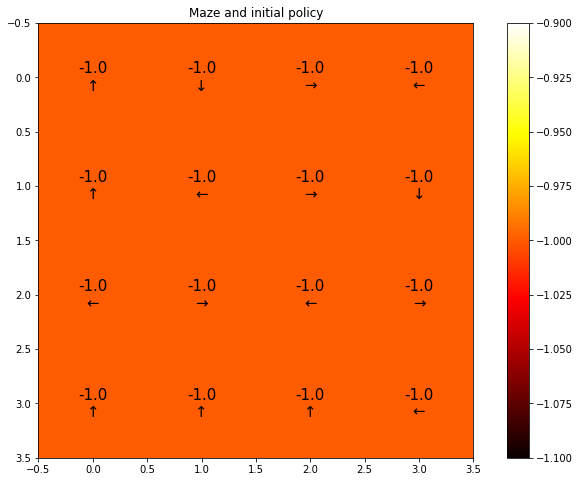

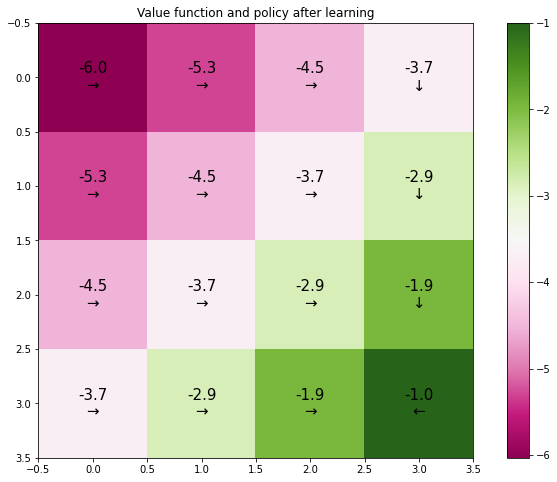

In [9]:
agent0._initialize()
agent0.runPolicyIterationFromValue()
agent0.visualize()